### 0. Imports and Setups

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque, defaultdict
import collections
import pickle
from tqdm import tqdm

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import time

# for plotting graphs
import matplotlib.pyplot as plt


In [68]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [69]:
!cp '/content/gdrive/MyDrive/Colab Notebooks/Deep RL Assignment/Env.py' .
!cp '/content/gdrive/MyDrive/Colab Notebooks/Deep RL Assignment/TM.npy' .

In [70]:
# The long training time is due to the fact of the current version of Tensorflow (v2) 
# which keras uses as it backend. We could switch back to v1 Tensorflow, the training time reduces significantly.
from keras import backend as K
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
jobs = 8 # Play around with this number
config = tf.ConfigProto(intra_op_parallelism_threads=jobs,
                         inter_op_parallelism_threads=jobs,
                         allow_soft_placement=True,
                         device_count={'CPU': jobs})
session = tf.Session(config=config)
K.set_session(session)

In [71]:

# Import the environment
from Env import CabDriver

#### 1. Defining Time Matrix

In [72]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [73]:
Time_matrix.shape

(5, 5, 24, 7)

In [74]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


**Observation**
- The time matrix is 4 dimensional - start_location, end_location, hour of day, day of the week
-  The max time taken between 2 consequtive points is 11 hours, time can increase by a day

###2.  Defining the MDP Environment

In [75]:
env = CabDriver()
action_space, state_space, state = env.reset()

In [76]:
action_space

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3)]

In [77]:
state_space

[[0, 0, 0],
 [0, 0, 1],
 [0, 0, 2],
 [0, 0, 3],
 [0, 0, 4],
 [0, 0, 5],
 [0, 0, 6],
 [0, 1, 0],
 [0, 1, 1],
 [0, 1, 2],
 [0, 1, 3],
 [0, 1, 4],
 [0, 1, 5],
 [0, 1, 6],
 [0, 2, 0],
 [0, 2, 1],
 [0, 2, 2],
 [0, 2, 3],
 [0, 2, 4],
 [0, 2, 5],
 [0, 2, 6],
 [0, 3, 0],
 [0, 3, 1],
 [0, 3, 2],
 [0, 3, 3],
 [0, 3, 4],
 [0, 3, 5],
 [0, 3, 6],
 [0, 4, 0],
 [0, 4, 1],
 [0, 4, 2],
 [0, 4, 3],
 [0, 4, 4],
 [0, 4, 5],
 [0, 4, 6],
 [0, 5, 0],
 [0, 5, 1],
 [0, 5, 2],
 [0, 5, 3],
 [0, 5, 4],
 [0, 5, 5],
 [0, 5, 6],
 [0, 6, 0],
 [0, 6, 1],
 [0, 6, 2],
 [0, 6, 3],
 [0, 6, 4],
 [0, 6, 5],
 [0, 6, 6],
 [0, 7, 0],
 [0, 7, 1],
 [0, 7, 2],
 [0, 7, 3],
 [0, 7, 4],
 [0, 7, 5],
 [0, 7, 6],
 [0, 8, 0],
 [0, 8, 1],
 [0, 8, 2],
 [0, 8, 3],
 [0, 8, 4],
 [0, 8, 5],
 [0, 8, 6],
 [0, 9, 0],
 [0, 9, 1],
 [0, 9, 2],
 [0, 9, 3],
 [0, 9, 4],
 [0, 9, 5],
 [0, 9, 6],
 [0, 10, 0],
 [0, 10, 1],
 [0, 10, 2],
 [0, 10, 3],
 [0, 10, 4],
 [0, 10, 5],
 [0, 10, 6],
 [0, 11, 0],
 [0, 11, 1],
 [0, 11, 2],
 [0, 11, 3],
 [0, 11, 4],
 [0,

**Observation**
- The state spaces are correctly initialized into a Vector [State, Day, Hour]

In [78]:
print ("The randomly initialized state is {}".format(state))

The randomly initialized state is [3, 12, 1]


In [79]:
#env.self_state_init_for_test([0,17,5])
env.requests(state)

([17, 11, 13, 7, 8, 18, 12, 16, 19, 5, 10, 3, 0],
 [(4, 0),
  (2, 3),
  (3, 0),
  (1, 3),
  (1, 4),
  (4, 1),
  (2, 4),
  (3, 4),
  (4, 2),
  (1, 0),
  (2, 1),
  (0, 3),
  (0, 0)])

**Observation** 
- Returns the correct randomised action, and corresponding index, based on the traffic (Poisson Random Variable) for the location

In [80]:
Time_matrix[4,3,17,5]

6.0

In [81]:
env.next_state_func(state,[4,3],Time_matrix)

([3, 20, 1], 0, 6.0, 2.0)

In [82]:
state = [0,1,2]
env.state_encod_arch1(state)

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0]

**Observation** 
- The universal state space and action space look properly initialized
- The current state is randomly initialized
- The request function returns random states based on Traffic
- The next state is being generated, and encoded correctly

#### 2. Utilties

In [83]:

#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


##### Epsilon- Greedy strategy

Way of selecting random actions with uniform distribution.
We can either select random action with epsilon probability or
We can select an action with 1-epsilon probably which will give maximum reward in a given state

Check epsilon decay over episodes

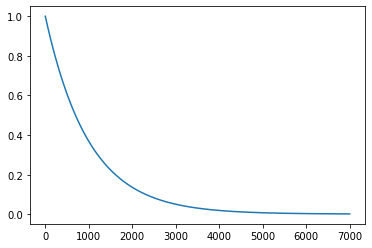

In [84]:
max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = -0.001
time_tic = np.arange(0,7000)
epsilon = []

#Number of episodes for training
for i in time_tic:
     epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(decay_rate*i))

plt.plot(time_tic, epsilon)
plt.show()


##### Initialize Tracking States

In [85]:
def initialize_tracking_states():
    state_action_pair = [((0, 0, 0), (0, 1)),
                         ((0, 1, 1), (3, 4)),
                         ((1, 2, 2), (0, 2)),
                         ((1, 2, 2), (2, 3)),
                         ((2, 3, 3), (2, 1)),
                         ((2, 3, 3), (3, 4)),
                         ((3, 4, 4), (3, 0)), 
                         ((4, 4, 4), (1, 0)),
                         ((4, 5, 5), (0, 1)),
                         ((4, 5, 5), (1, 2))]

    for state, action in state_action_pair:
        if state not in tracked_states:
            tracked_states[state] = defaultdict()
        tracked_states[state][action] = list()




##### Persist q-values corresponding for tracked states

In [86]:
def update_tracking_states(driver):
    for state in tracked_states.keys():
        encoded_state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
        q_predict = driver.model.predict(encoded_state)
        

        for action in tracked_states[state].keys():            
            action_index = list(
                filter(
                    lambda x: action == env.action_space[x],
                    range(0, len(env.action_space))))[0]
            q_value = q_predict[0][action_index]            
            tracked_states[state][action].append(q_value)

## 3. Defining the Agent Class

In this framework, we need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.


## Hyper parameters

*  state_size : vector length of encoded states (number of neurons in input layer) 
*   action_size : vector length of predicted q_values for all actions 
*  learning_rate
*  discount_factor
*  batch_size : batch size used in neural network for training
*  memory_length : replay memory buffer size



In [87]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        #self.epsilon_decay = -0.0005 #for 15k
        #self.epsilon_decay = -0.00015 #for 20k
        #self.epsilon_decay = -0.01 # for 1k
        #self.epsilon_decay = -0.1 # for 100    
        self.epsilon_decay = -0.001 # for 7k    
        self.epsilon_min = 0.001 
     
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        input_shape = self.state_size
        model = Sequential()
        # Input layer : 'state_size'       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        # Hidden Layers
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # Output Layer : 'action_size'
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary()
        return model

  
    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)            
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]
     
            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
           
            # initialize input state vector S
            state_input = np.zeros((self.batch_size, self.state_size))
            # initialize input state vector S'
            next_state_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate state_input, next_state_input and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                state_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                next_state_input[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # once the input matrices S and S' have been created, perform a feed-forward.
            # this will generate q-values for all possible actions of a batch input

            # generate Q(s, a)
            state_q_values = self.model.predict(state_input)
            # generate Q(s', a)
            next_state_q_values = self.model.predict(next_state_input)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    state_q_values[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    state_q_values[i][actions[i]] = rewards[i] + self.discount_factor * np.max(next_state_q_values[i])
            # model fit
            self.model.fit(state_input, state_q_values, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):        
        save_obj(self.model.get_weights(),  name)
    

## Initialization

In [88]:
#Initiaze sample tracking states
tracked_states = defaultdict()
initialize_tracking_states()
tracked_states

defaultdict(None,
            {(0, 0, 0): defaultdict(None, {(0, 1): []}),
             (0, 1, 1): defaultdict(None, {(3, 4): []}),
             (1, 2, 2): defaultdict(None, {(0, 2): [], (2, 3): []}),
             (2, 3, 3): defaultdict(None, {(2, 1): [], (3, 4): []}),
             (3, 4, 4): defaultdict(None, {(3, 0): []}),
             (4, 4, 4): defaultdict(None, {(1, 0): []}),
             (4, 5, 5): defaultdict(None, {(0, 1): [], (1, 2): []})})

### 4. Training - DQN block

In [89]:
#Initialize the DQN Block 

episode_time = 24*30 #30 days before which car has to be recharged
total_episodes = 7000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# to store rewards in each episode
rewards_per_episode, episodes = [], []





In [90]:

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1184      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 21)                693       
                                                                 
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________


## 5. Training Iteration

In [91]:
start_time = time.time()
score_tracked = []


for episode in tqdm(range(total_episodes)):

    terminal_state = False
    score = 0
    track_reward = False

    #reset at the start of each episode
    env = CabDriver()
    action_space, state_space, current_state = env.reset()
    

    total_time = 0
    while not terminal_state:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(current_state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        current_action_idx = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(current_state, env.action_space[current_action_idx], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
          # if ride does not complete in stipulated time skip
          # it and move to next episode.
          terminal_state = True
        else:
          # 5. Append the experience to the memory
          agent.append_sample(current_state, current_action_idx, reward, next_state, terminal_state)
          # 6. Train the model by calling function agent.train_model
          agent.train_model()
          # 7. Keep a track of rewards, Q-values, loss
          score += reward
          current_state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
      

    # epsilon decay
    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay * episode)

    # every 100 episodes:
    if ((episode + 1) % 100 == 0):
        print("\nEpisode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}\n".format(episode + 1,
                                                score,len(agent.memory),agent.epsilon, total_time))
        
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 50 == 0):       
        update_tracking_states(agent)

    # Total rewards per episode
    score_tracked.append(score)

           
elapsed_time = time.time() - start_time
print("\nElapsed Time :", elapsed_time, "\n")

  0%|          | 0/7000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
  1%|▏         | 100/7000 [01:20<1:28:11,  1.30it/s]


Episode 100, reward -234.0, memory_length 2000, epsilon 0.9058369653155249 total_time 722.0



  3%|▎         | 200/7000 [02:38<1:35:23,  1.19it/s]


Episode 200, reward -253.0, memory_length 2000, epsilon 0.8197303434395927 total_time 722.0



  4%|▍         | 300/7000 [03:54<1:24:25,  1.32it/s]


Episode 300, reward 115.0, memory_length 2000, epsilon 0.7418178500255755 total_time 721.0



  6%|▌         | 400/7000 [05:10<1:21:17,  1.35it/s]


Episode 400, reward -332.0, memory_length 2000, epsilon 0.6713197106520924 total_time 726.0



  7%|▋         | 500/7000 [06:26<1:19:18,  1.37it/s]


Episode 500, reward 295.0, memory_length 2000, epsilon 0.6075303562450509 total_time 724.0



  9%|▊         | 600/7000 [07:40<1:20:50,  1.32it/s]


Episode 600, reward -53.0, memory_length 2000, epsilon 0.5498113615052026 total_time 724.0



 10%|█         | 700/7000 [08:59<1:24:38,  1.24it/s]


Episode 700, reward 12.0, memory_length 2000, epsilon 0.49758505533316705 total_time 726.0



 11%|█▏        | 800/7000 [10:16<1:16:50,  1.34it/s]


Episode 800, reward -91.0, memory_length 2000, epsilon 0.450328739302907 total_time 726.0



 13%|█▎        | 900/7000 [11:32<1:15:58,  1.34it/s]


Episode 900, reward -146.0, memory_length 2000, epsilon 0.4075694563201952 total_time 725.0



 14%|█▍        | 1000/7000 [12:50<1:17:53,  1.28it/s]


Episode 1000, reward -198.0, memory_length 2000, epsilon 0.36887925710904923 total_time 722.0



 16%|█▌        | 1100/7000 [14:02<1:12:21,  1.36it/s]


Episode 1100, reward 6.0, memory_length 2000, epsilon 0.33387091715153905 total_time 725.0



 17%|█▋        | 1200/7000 [15:17<1:09:57,  1.38it/s]


Episode 1200, reward 9.0, memory_length 2000, epsilon 0.30219406121466036 total_time 725.0



 19%|█▊        | 1300/7000 [16:31<1:07:15,  1.41it/s]


Episode 1300, reward -155.0, memory_length 2000, epsilon 0.2735316566772381 total_time 724.0



 20%|██        | 1400/7000 [17:57<1:17:41,  1.20it/s]


Episode 1400, reward -247.0, memory_length 2000, epsilon 0.2475968405608947 total_time 722.0



 21%|██▏       | 1500/7000 [19:16<1:05:27,  1.40it/s]


Episode 1500, reward 36.0, memory_length 2000, epsilon 0.22413004850894513 total_time 723.0



 23%|██▎       | 1600/7000 [20:25<1:00:23,  1.49it/s]


Episode 1600, reward -13.0, memory_length 2000, epsilon 0.20289641697907232 total_time 721.0



 24%|██▍       | 1700/7000 [21:34<1:03:25,  1.39it/s]


Episode 1700, reward -131.0, memory_length 2000, epsilon 0.18368343265005527 total_time 726.0



 26%|██▌       | 1800/7000 [22:45<1:07:42,  1.28it/s]


Episode 1800, reward -585.0, memory_length 2000, epsilon 0.16629880551702214 total_time 729.0



 27%|██▋       | 1900/7000 [24:03<1:17:06,  1.10it/s]


Episode 1900, reward -355.0, memory_length 2000, epsilon 0.15056854438845055 total_time 732.0



 29%|██▊       | 2000/7000 [25:26<1:03:42,  1.31it/s]


Episode 2000, reward -43.0, memory_length 2000, epsilon 0.13633521552384237 total_time 725.0



 30%|███       | 2100/7000 [26:35<55:46,  1.46it/s]


Episode 2100, reward 275.0, memory_length 2000, epsilon 0.12345636698393364 total_time 728.0



 31%|███▏      | 2200/7000 [27:42<56:15,  1.42it/s]


Episode 2200, reward 94.0, memory_length 2000, epsilon 0.11180310292380648 total_time 721.0



 33%|███▎      | 2300/7000 [28:51<53:59,  1.45it/s]


Episode 2300, reward 833.0, memory_length 2000, epsilon 0.10125879355994974 total_time 723.0



 34%|███▍      | 2400/7000 [30:02<57:52,  1.32it/s]


Episode 2400, reward -246.0, memory_length 2000, epsilon 0.09171790790018519 total_time 736.0



 36%|███▌      | 2500/7000 [31:15<51:36,  1.45it/s]


Episode 2500, reward 261.0, memory_length 2000, epsilon 0.08308495755402755 total_time 726.0



 37%|███▋      | 2600/7000 [32:22<48:22,  1.52it/s]


Episode 2600, reward -156.0, memory_length 2000, epsilon 0.07527354105277761 total_time 725.0



 39%|███▊      | 2700/7000 [33:29<48:44,  1.47it/s]


Episode 2700, reward 54.0, memory_length 2000, epsilon 0.06820547911458316 total_time 730.0



 40%|████      | 2800/7000 [34:34<46:23,  1.51it/s]


Episode 2800, reward -8.0, memory_length 2000, epsilon 0.061810032199909035 total_time 726.0



 41%|████▏     | 2900/7000 [35:41<43:27,  1.57it/s]


Episode 2900, reward -49.0, memory_length 2000, epsilon 0.056023192526449245 total_time 725.0



 43%|████▎     | 3000/7000 [36:49<47:55,  1.39it/s]


Episode 3000, reward 82.0, memory_length 2000, epsilon 0.05078704345772784 total_time 726.0



 44%|████▍     | 3100/7000 [37:59<44:32,  1.46it/s]


Episode 3100, reward -57.0, memory_length 2000, epsilon 0.046049179853934565 total_time 728.0



 46%|████▌     | 3200/7000 [39:05<43:03,  1.47it/s]


Episode 3200, reward 77.0, memory_length 2000, epsilon 0.041762183583671716 total_time 723.0



 47%|████▋     | 3300/7000 [40:12<39:53,  1.55it/s]


Episode 3300, reward 7.0, memory_length 2000, epsilon 0.03788314894735731 total_time 725.0



 49%|████▊     | 3400/7000 [41:17<37:13,  1.61it/s]


Episode 3400, reward 209.0, memory_length 2000, epsilon 0.034373253262562506 total_time 725.0



 50%|█████     | 3500/7000 [42:22<38:30,  1.51it/s]


Episode 3500, reward -199.0, memory_length 2000, epsilon 0.031197368313557215 total_time 722.0



 51%|█████▏    | 3600/7000 [43:29<36:43,  1.54it/s]


Episode 3600, reward 394.0, memory_length 2000, epsilon 0.02832370877632001 total_time 724.0



 53%|█████▎    | 3700/7000 [44:35<38:13,  1.44it/s]


Episode 3700, reward 129.0, memory_length 2000, epsilon 0.02572351410033188 total_time 729.0



 54%|█████▍    | 3800/7000 [45:42<35:15,  1.51it/s]


Episode 3800, reward 111.0, memory_length 2000, epsilon 0.02337076066331995 total_time 722.0



 56%|█████▌    | 3900/7000 [46:48<35:27,  1.46it/s]


Episode 3900, reward -29.0, memory_length 2000, epsilon 0.021241901318098833 total_time 725.0



 57%|█████▋    | 4000/7000 [47:54<32:12,  1.55it/s]


Episode 4000, reward 64.0, memory_length 2000, epsilon 0.019315629724807232 total_time 731.0



 59%|█████▊    | 4100/7000 [49:01<33:20,  1.45it/s]


Episode 4100, reward 435.0, memory_length 2000, epsilon 0.017572667109897248 total_time 722.0



 60%|██████    | 4200/7000 [50:09<32:56,  1.42it/s]


Episode 4200, reward 275.0, memory_length 2000, epsilon 0.015995569317688897 total_time 728.0



 61%|██████▏   | 4300/7000 [51:16<29:44,  1.51it/s]


Episode 4300, reward 300.0, memory_length 2000, epsilon 0.014568552223396872 total_time 722.0



 63%|██████▎   | 4400/7000 [52:23<28:50,  1.50it/s]


Episode 4400, reward 177.0, memory_length 2000, epsilon 0.013277333760304506 total_time 726.0



 64%|██████▍   | 4500/7000 [53:32<27:41,  1.50it/s]


Episode 4500, reward 9.0, memory_length 2000, epsilon 0.012108990980039654 total_time 732.0



 66%|██████▌   | 4600/7000 [54:40<29:00,  1.38it/s]


Episode 4600, reward 155.0, memory_length 2000, epsilon 0.01105183071536384 total_time 721.0



 67%|██████▋   | 4700/7000 [55:46<26:52,  1.43it/s]


Episode 4700, reward 445.0, memory_length 2000, epsilon 0.01009527255102437 total_time 723.0



 69%|██████▊   | 4800/7000 [56:53<26:45,  1.37it/s]


Episode 4800, reward 28.0, memory_length 2000, epsilon 0.009229742931402222 total_time 722.0



 70%|███████   | 4900/7000 [58:05<23:34,  1.48it/s]


Episode 4900, reward 285.0, memory_length 2000, epsilon 0.008446579345149679 total_time 725.0



 71%|███████▏  | 5000/7000 [59:12<23:23,  1.43it/s]


Episode 5000, reward -205.0, memory_length 2000, epsilon 0.007737943627865145 total_time 721.0



 73%|███████▎  | 5100/7000 [1:00:21<22:53,  1.38it/s]


Episode 5100, reward -35.0, memory_length 2000, epsilon 0.0070967435151093414 total_time 725.0



 74%|███████▍  | 5200/7000 [1:01:30<20:53,  1.44it/s]


Episode 5200, reward -1.0, memory_length 2000, epsilon 0.006516561660639018 total_time 721.0



 76%|███████▌  | 5300/7000 [1:02:36<19:41,  1.44it/s]


Episode 5300, reward -121.0, memory_length 2000, epsilon 0.005991591409448773 total_time 731.0



 77%|███████▋  | 5400/7000 [1:03:45<18:28,  1.44it/s]


Episode 5400, reward 261.0, memory_length 2000, epsilon 0.005516578682816105 total_time 734.0



 79%|███████▊  | 5500/7000 [1:04:49<15:48,  1.58it/s]


Episode 5500, reward 171.0, memory_length 2000, epsilon 0.005086769393715577 total_time 724.0



 80%|████████  | 5600/7000 [1:05:59<14:41,  1.59it/s]


Episode 5600, reward 185.0, memory_length 2000, epsilon 0.004697861866317988 total_time 723.0



 81%|████████▏ | 5700/7000 [1:07:05<14:11,  1.53it/s]


Episode 5700, reward 194.0, memory_length 2000, epsilon 0.004345963783372804 total_time 734.0



 83%|████████▎ | 5800/7000 [1:08:13<13:32,  1.48it/s]


Episode 5800, reward 126.0, memory_length 2000, epsilon 0.0040275532305888775 total_time 727.0



 84%|████████▍ | 5900/7000 [1:09:22<12:58,  1.41it/s]


Episode 5900, reward 230.0, memory_length 2000, epsilon 0.003739443448132469 total_time 725.0



 86%|████████▌ | 6000/7000 [1:10:36<14:24,  1.16it/s]


Episode 6000, reward -525.0, memory_length 2000, epsilon 0.0034787509364637083 total_time 730.0



 87%|████████▋ | 6100/7000 [1:12:00<13:40,  1.10it/s]


Episode 6100, reward -511.0, memory_length 2000, epsilon 0.003242866597304039 total_time 721.0



 89%|████████▊ | 6200/7000 [1:13:15<08:52,  1.50it/s]


Episode 6200, reward 60.0, memory_length 2000, epsilon 0.0030294296209036863 total_time 731.0



 90%|█████████ | 6300/7000 [1:14:27<08:43,  1.34it/s]


Episode 6300, reward 468.0, memory_length 2000, epsilon 0.0028363038582641864 total_time 721.0



 91%|█████████▏| 6400/7000 [1:15:34<06:37,  1.51it/s]


Episode 6400, reward 107.0, memory_length 2000, epsilon 0.002661556441841238 total_time 729.0



 93%|█████████▎| 6500/7000 [1:16:44<05:49,  1.43it/s]


Episode 6500, reward 478.0, memory_length 2000, epsilon 0.0025034384407566406 total_time 726.0



 94%|█████████▍| 6600/7000 [1:17:53<04:51,  1.37it/s]


Episode 6600, reward 215.0, memory_length 2000, epsilon 0.0023603673569102483 total_time 724.0



 96%|█████████▌| 6700/7000 [1:19:02<03:36,  1.38it/s]


Episode 6700, reward 397.0, memory_length 2000, epsilon 0.0022309112868070724 total_time 733.0



 97%|█████████▋| 6800/7000 [1:20:10<02:14,  1.48it/s]


Episode 6800, reward -56.0, memory_length 2000, epsilon 0.002113774590585831 total_time 721.0



 99%|█████████▊| 6900/7000 [1:21:32<01:35,  1.05it/s]


Episode 6900, reward 95.0, memory_length 2000, epsilon 0.002007784924819742 total_time 728.0



100%|██████████| 7000/7000 [1:22:55<00:00,  1.41it/s]


Episode 7000, reward 126.0, memory_length 2000, epsilon 0.0019118815093094581 total_time 722.0


Elapsed Time : 4975.208893537521 



**Observation** 
- The 'total_time' above includes the 'last ride' time also in each episode. Although it exceeds 24*30 = 720, our code drops the last ride from the replay buffer. So the total ride time per episode is limited to < 720


In [92]:
agent.save(name="model_weights")

### 5. Tracking Convergence

In [93]:
 tracked_states_plotting=[]
 for st in tracked_states.keys():
        for ac in tracked_states[st].keys():
            number_of_tracked_q_values = len(list(filter(lambda x: x!= 0, tracked_states[st][ac])))
            print('state - {0} - action - {1} - {2}'.format(st, ac, number_of_tracked_q_values))
            # selecting only the states with non-zero values for plotting
            if (number_of_tracked_q_values):              
              tracked_states_plotting.append((st,ac))



state - (0, 0, 0) - action - (0, 1) - 140
state - (0, 1, 1) - action - (3, 4) - 138
state - (1, 2, 2) - action - (0, 2) - 138
state - (1, 2, 2) - action - (2, 3) - 140
state - (2, 3, 3) - action - (2, 1) - 140
state - (2, 3, 3) - action - (3, 4) - 138
state - (3, 4, 4) - action - (3, 0) - 128
state - (4, 4, 4) - action - (1, 0) - 140
state - (4, 5, 5) - action - (0, 1) - 140
state - (4, 5, 5) - action - (1, 2) - 138


**Observation** 
- There are values in the saved states which can be plotted


**draw convergence plot for a state - action pair**

In [94]:
def plot_q_val_convergence(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.plot(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")

In [95]:
def plot_q_val_log_convergence(state, action):

    tracked_q_values = tracked_states[state][action]
    number_of_tracked_episodes = len(tracked_q_values)
    plt.semilogy(range(0, number_of_tracked_episodes), tracked_q_values)
        
    plt.ylabel("Q_value")
    
    plt.title("State : {0} - Action : {1}".format(state, action))
    plt.legend(["Q-value"], loc="lower right")



**Display convergence of tracked states**

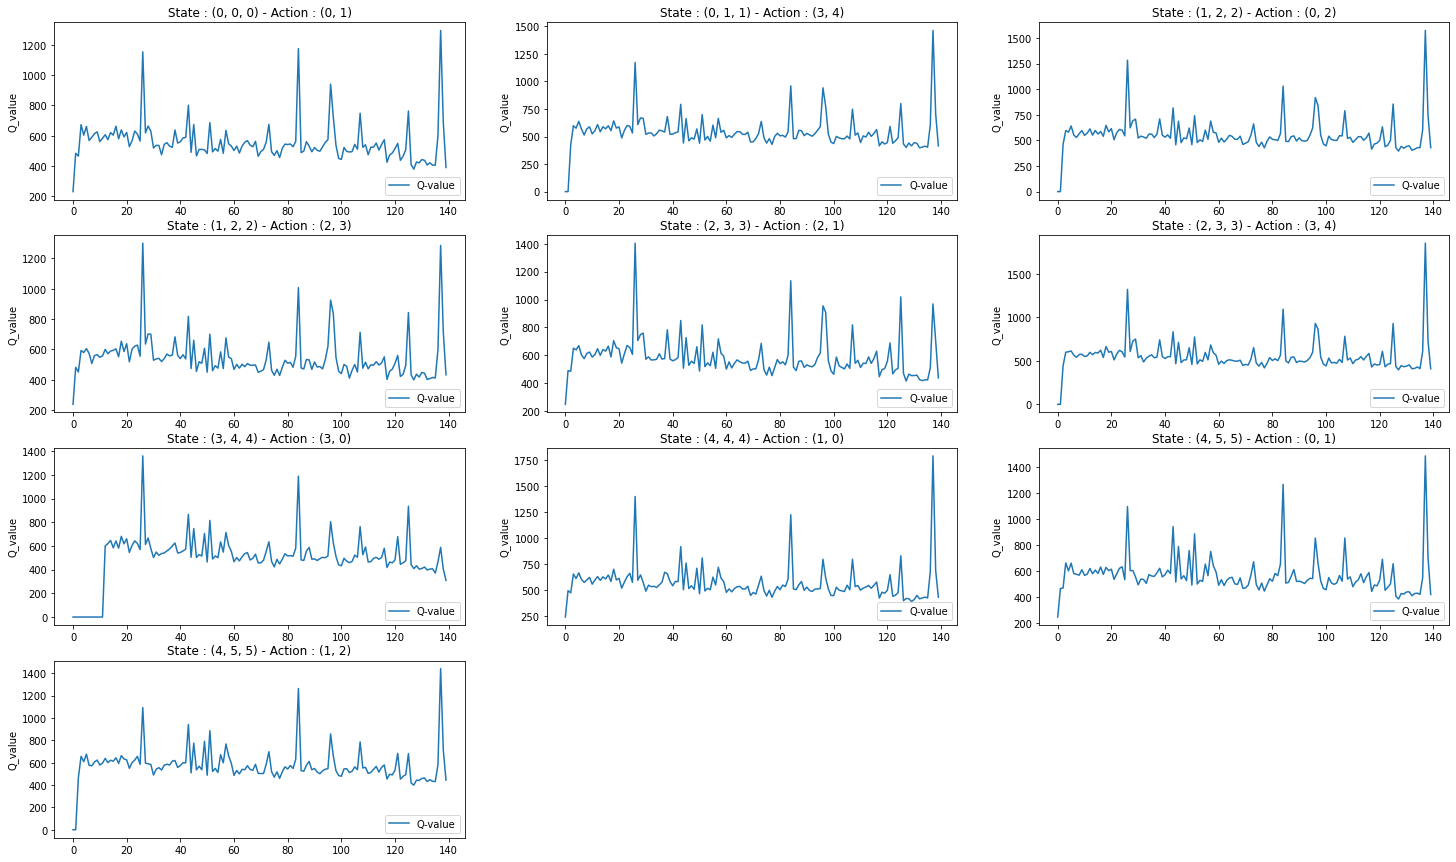

In [96]:
plt.figure(0, figsize=(25, 15))
i = 0
for state, action in tracked_states_plotting:
    plt.subplot(4,3, i + 1)
    plot_q_val_convergence(state, action)
    i +=1

**Observation** 
- The Q Value is steadily increasing as the number of runs are increasing, which shows that the model is learning

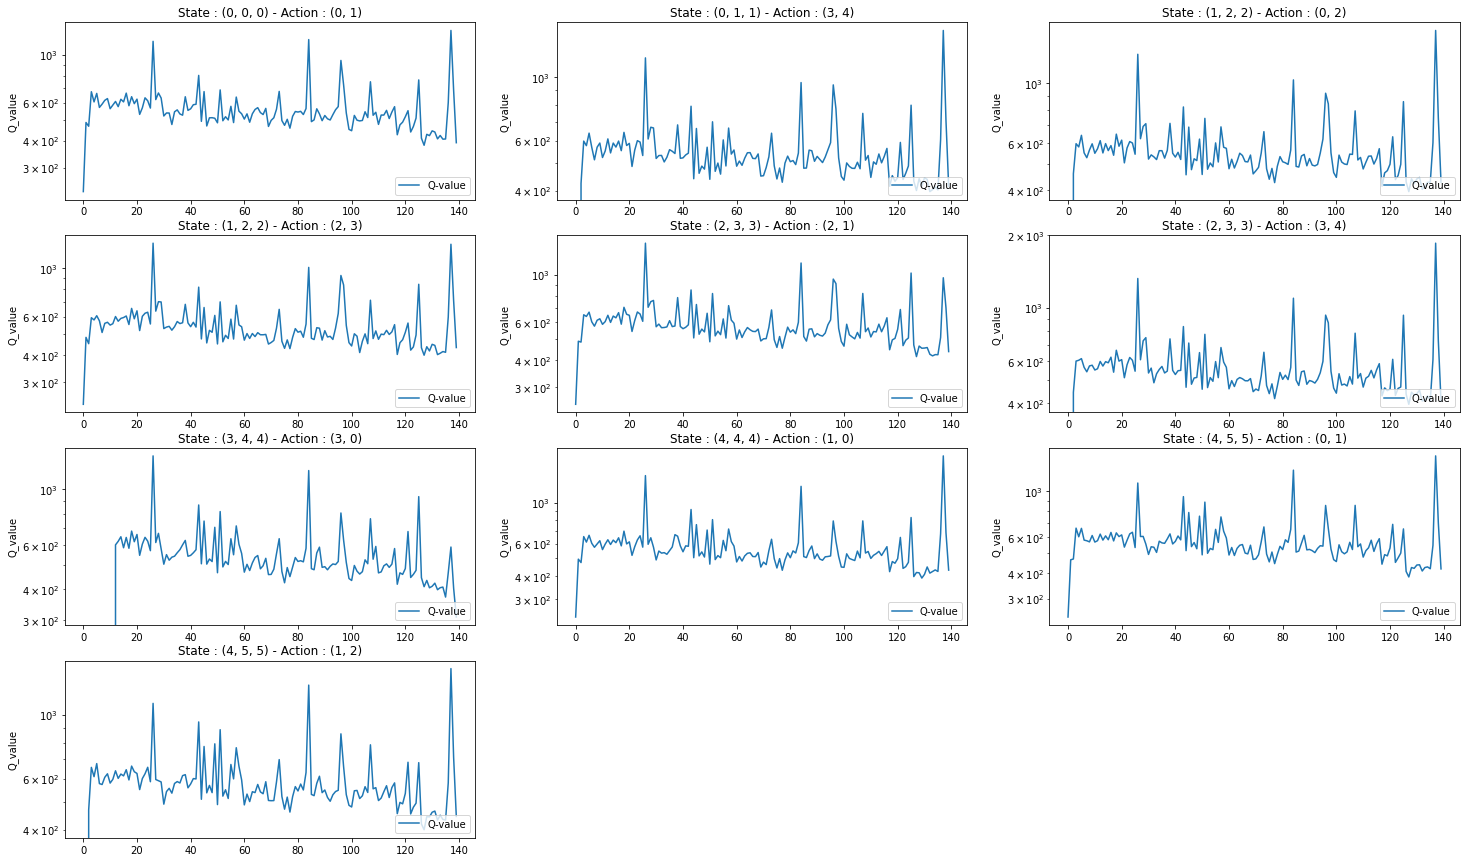

In [97]:
plt.figure(0, figsize=(25, 15))
i = 0
for state, action in tracked_states_plotting:
    plt.subplot(4,3, i + 1)
    plot_q_val_log_convergence(state, action)
    i +=1

**Observation** 
- The Log Scale is not that useful in smoothening the curve as the number of runs are restricted to 7000. 
- We can repeat the experiment with close to 15K runs and check for improvement of Q Values

**Plotting Average Monthly Rewards**

In [98]:
!cp model_weights.pkl '/content/gdrive/MyDrive/Colab Notebooks/Deep RL Assignment/model_weights.pkl'

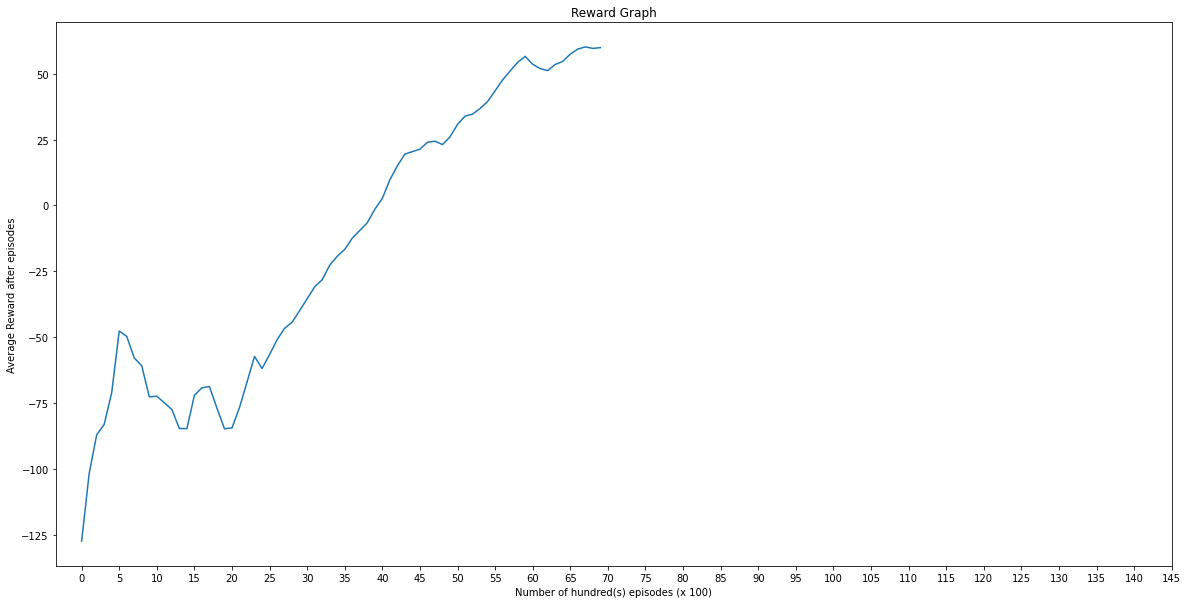

In [100]:
avg_monthly_rewards = [
    np.mean(rewards_per_episode[0:x + 99])
    for x in range(0, total_episodes, 100)
]

plt.figure(figsize=(20, 10))

plt.plot(range(0, len(avg_monthly_rewards)), avg_monthly_rewards)

plt.xlabel("Number of hundred(s) episodes (x 100)")
plt.ylabel("Average Reward after episodes")
plt.title("Reward Graph")
plt.xticks(range(0, 150, 5))

plt.show()

**Conclusion**
- We have been able to create a Deep Q Model, which learns the Env and able to predict Actions, which can maximise the reward, which is the goal of this experiment
- As seen below, we start with a low Reward, and slowly the graph rises up to better rewards
- Having said that, we need to run many more iterations, to get to better results, which we havent done due to infrastructure and time constraints.